# CARE Prediction
Please run the `1_CARETraining.ipynb` notebook before going through this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tifffile import imread

from ppn2v.pn2v.utils import PSNR
from ppn2v.pn2v import utils
from ppn2v.pn2v import prediction

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calculate the 'mean' and 'std' for normalization
path='../../../data/Convallaria_diaphragm/'

# Load the test data
dataTest=imread(path+"20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]


### Load the Network and Noise Model
Ensure that ```dataName``` is set same as in ```1_CareTraining.ipynb```.

In [3]:
dataName = 'convallaria' # Use the same name as used in 1_CareTraining.ipynb. This is a part of model name created in 1_CareTraining.ipynb 
nameModel=dataName+'_care'

In [4]:
# Load the network, created in the '1_CareTraining.ipynb' notebook
net=torch.load(path+"/last_"+nameModel+".net")

/home/lalit/Desktop/01_Softwares/anaconda3/envs/ppn2vEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### Evaluation

image: 0
PSNR input 29.009240856174337
PSNR CARE 36.73760103978519
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR CARE 36.672442579535186
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR CARE 36.67733373068818
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR CARE 36.72687774062598
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR CARE 36.7252719191944
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR CARE 36.6842364781735
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR CARE 36.74243576310917
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR CARE 36.725035910102626
-----------------------------------
image: 8
PSNR input 29.003677692102134
PSNR CARE 36.803245898590916
-----------------------------------
image: 9
PSNR input 28.991348421709475
PSNR CARE 36.734285304580936
-----

image: 80
PSNR input 28.957840957402226
PSNR CARE 36.70531554904982
-----------------------------------
image: 81
PSNR input 28.940414811710117
PSNR CARE 36.68340995352405
-----------------------------------
image: 82
PSNR input 28.991915288787613
PSNR CARE 36.78352872151376
-----------------------------------
image: 83
PSNR input 29.023941316831703
PSNR CARE 36.739908969888646
-----------------------------------
image: 84
PSNR input 28.979363428547718
PSNR CARE 36.74737046494517
-----------------------------------
image: 85
PSNR input 28.977253844527432
PSNR CARE 36.825809728550226
-----------------------------------
image: 86
PSNR input 28.93295570861992
PSNR CARE 36.66883684482477
-----------------------------------
image: 87
PSNR input 28.911831115485445
PSNR CARE 36.6348725850998
-----------------------------------
image: 88
PSNR input 28.98025614483497
PSNR CARE 36.70942402071384
-----------------------------------
image: 89
PSNR input 28.94848133894456
PSNR CARE 36.6818749711320

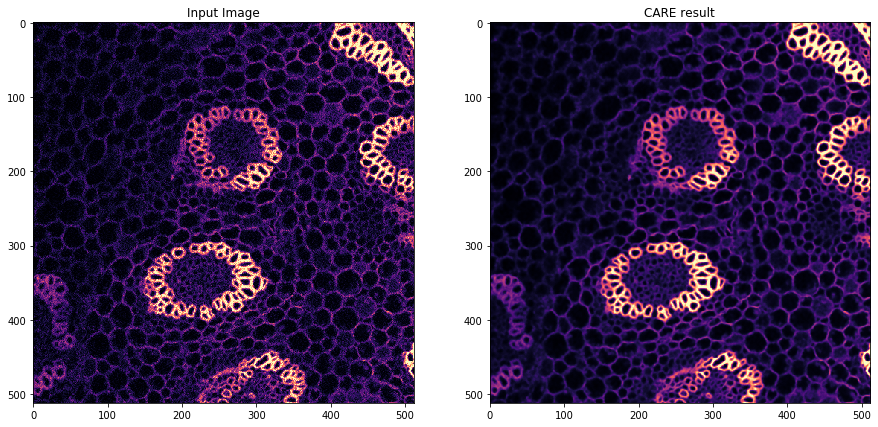

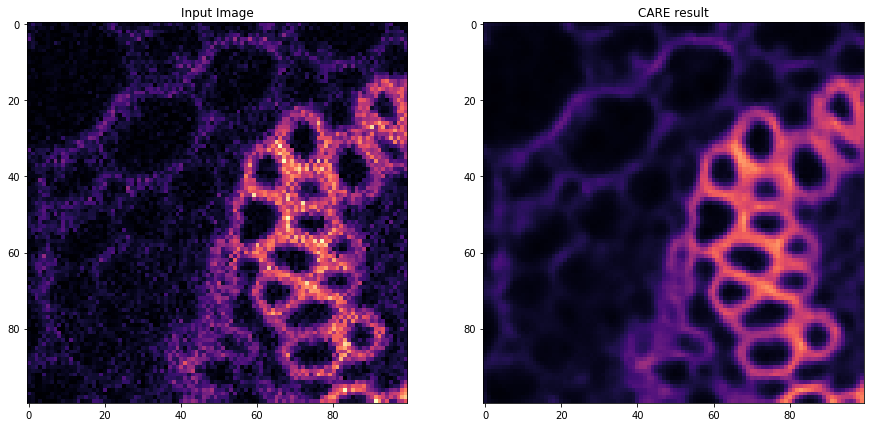

Avg PSNR CARE: 36.725447933136635 +-(2SEM) 0.00851437998854407


In [9]:
# Now we are processing data and calculating PSNR values.
careRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    careResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    carePrior=PSNR(gt, careResult, rangePSNR )
    careRes.append(carePrior)

    print ("image:",index)
    print ("PSNR input", PSNR(gt, im, rangePSNR))
    print ("PSNR CARE", carePrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/raw_image.png', im[100:200,150:250])

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/CARE_denoised_image.png', careResult[100:200,150:250])
plt.show()

print("Avg PSNR CARE:", np.mean(np.array(careRes) ), '+-(2SEM)',2*np.std(np.array(careRes) )/np.sqrt(float(len(careRes)) ) )